# VVIX/VIX Ratio Hypothesis Analysis

This notebook tests the hypothesis that the relationship between VVIX and VIX can signal market confidence and predict future returns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
print("Libraries imported.")

Libraries imported.


## 1. Data Collection and Preparation

In [2]:
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

tickers = ['^VIX', '^VVIX', 'SPY']
data = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
data = data.dropna()

data.rename(columns={'^VIX': 'vix', '^VVIX': 'vvix', 'SPY': 'spy'}, inplace=True)

data['vvix_vix_ratio'] = data['vvix'] / data['vix']
data['spy_return'] = data['spy'].pct_change()

for days in [1, 5, 10, 20]:
    data[f'spy_fwd_return_{days}d'] = data['spy'].pct_change(days).shift(-days)

data = data.dropna()

print(f"Data prepared with {len(data)} observations.")
data.head()

Data prepared with 1227 observations.


Ticker,spy,vix,vvix,vvix_vix_ratio,spy_return,spy_fwd_return_1d,spy_fwd_return_5d,spy_fwd_return_10d,spy_fwd_return_20d
Date,,,,,,,,,
2020-11-19,333.544312,23.110001,114.150002,4.939420,0.004210,-0.006848,0.016462,0.033736,0.036261
2020-11-20,331.260132,23.700001,113.989998,4.809704,-0.006848,0.005995,0.018940,0.038725,0.039676
2020-11-23,333.245911,22.660000,109.849998,4.847749,0.005995,0.016114,0.023947,0.035556,0.031739
2020-11-24,338.615814,21.639999,104.559998,4.831793,0.016114,-0.001542,0.009829,0.009994,0.016290
2020-11-25,338.093658,21.250000,103.459999,4.868706,-0.001542,0.002785,0.011112,0.011223,0.021819


## 2. Defining Market Regimes

We'll define four regimes based on the user's hypothesis using quantiles for 'high' and 'low' levels.

In [3]:
vix_low_q = data['vix'].quantile(0.25)
vix_high_q = data['vix'].quantile(0.75)
vvix_low_q = data['vvix'].quantile(0.25)
vvix_high_q = data['vvix'].quantile(0.75)

def get_regime(row):
    vix_is_high = row['vix'] > vix_high_q
    vix_is_low = row['vix'] < vix_low_q
    vvix_is_high = row['vvix'] > vvix_high_q
    vvix_is_low = row['vvix'] < vvix_low_q

    if vvix_is_low and vix_is_high:
        return 'Confident High Vol'
    elif vvix_is_low and vix_is_low:
        return 'Confident Low Vol'
    elif vvix_is_high and vix_is_high:
        return 'Panic High Vol'
    elif vvix_is_high and vix_is_low:
        return 'Panic Low Vol'
    else:
        return 'Neutral'

data['regime'] = data.apply(get_regime, axis=1)

print("Regime counts:")
print(data['regime'].value_counts())

Regime counts:
regime
Neutral               849
Confident Low Vol     179
Panic High Vol        151
Confident High Vol     45
Panic Low Vol           3
Name: count, dtype: int64


## 3. Visualizing the Regimes

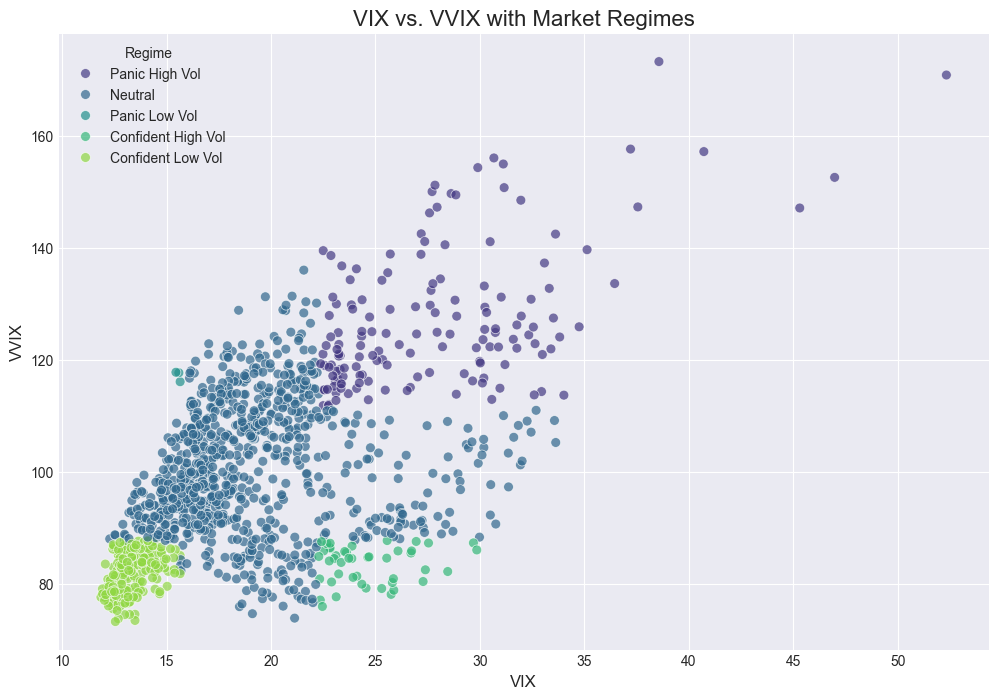

In [4]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='vix', y='vvix', hue='regime', palette='viridis', s=50, alpha=0.7)
plt.title('VIX vs. VVIX with Market Regimes', fontsize=16)
plt.xlabel('VIX', fontsize=12)
plt.ylabel('VVIX', fontsize=12)
plt.legend(title='Regime')
plt.show()

## 4. Analyzing Forward Returns per Regime

In [5]:
fwd_return_cols = [f'spy_fwd_return_{d}d' for d in [1, 5, 10, 20]]
regime_analysis = data.groupby('regime')[fwd_return_cols].mean() * 100

print("Average Forward Returns per Regime (%):")
print(regime_analysis)

Average Forward Returns per Regime (%):
Ticker              spy_fwd_return_1d  spy_fwd_return_5d  spy_fwd_return_10d  \
regime                                                                         
Confident High Vol           0.176448           0.582265            1.269257   
Confident Low Vol            0.132507           0.561892            0.983948   
Neutral                      0.024047           0.146091            0.345836   
Panic High Vol               0.161939           0.879003            1.508030   
Panic Low Vol                0.213779          -1.215546            0.700130   

Ticker              spy_fwd_return_20d  
regime                                  
Confident High Vol            2.192378  
Confident Low Vol             1.538399  
Neutral                       0.909959  
Panic High Vol                2.252187  
Panic Low Vol                 1.189599  


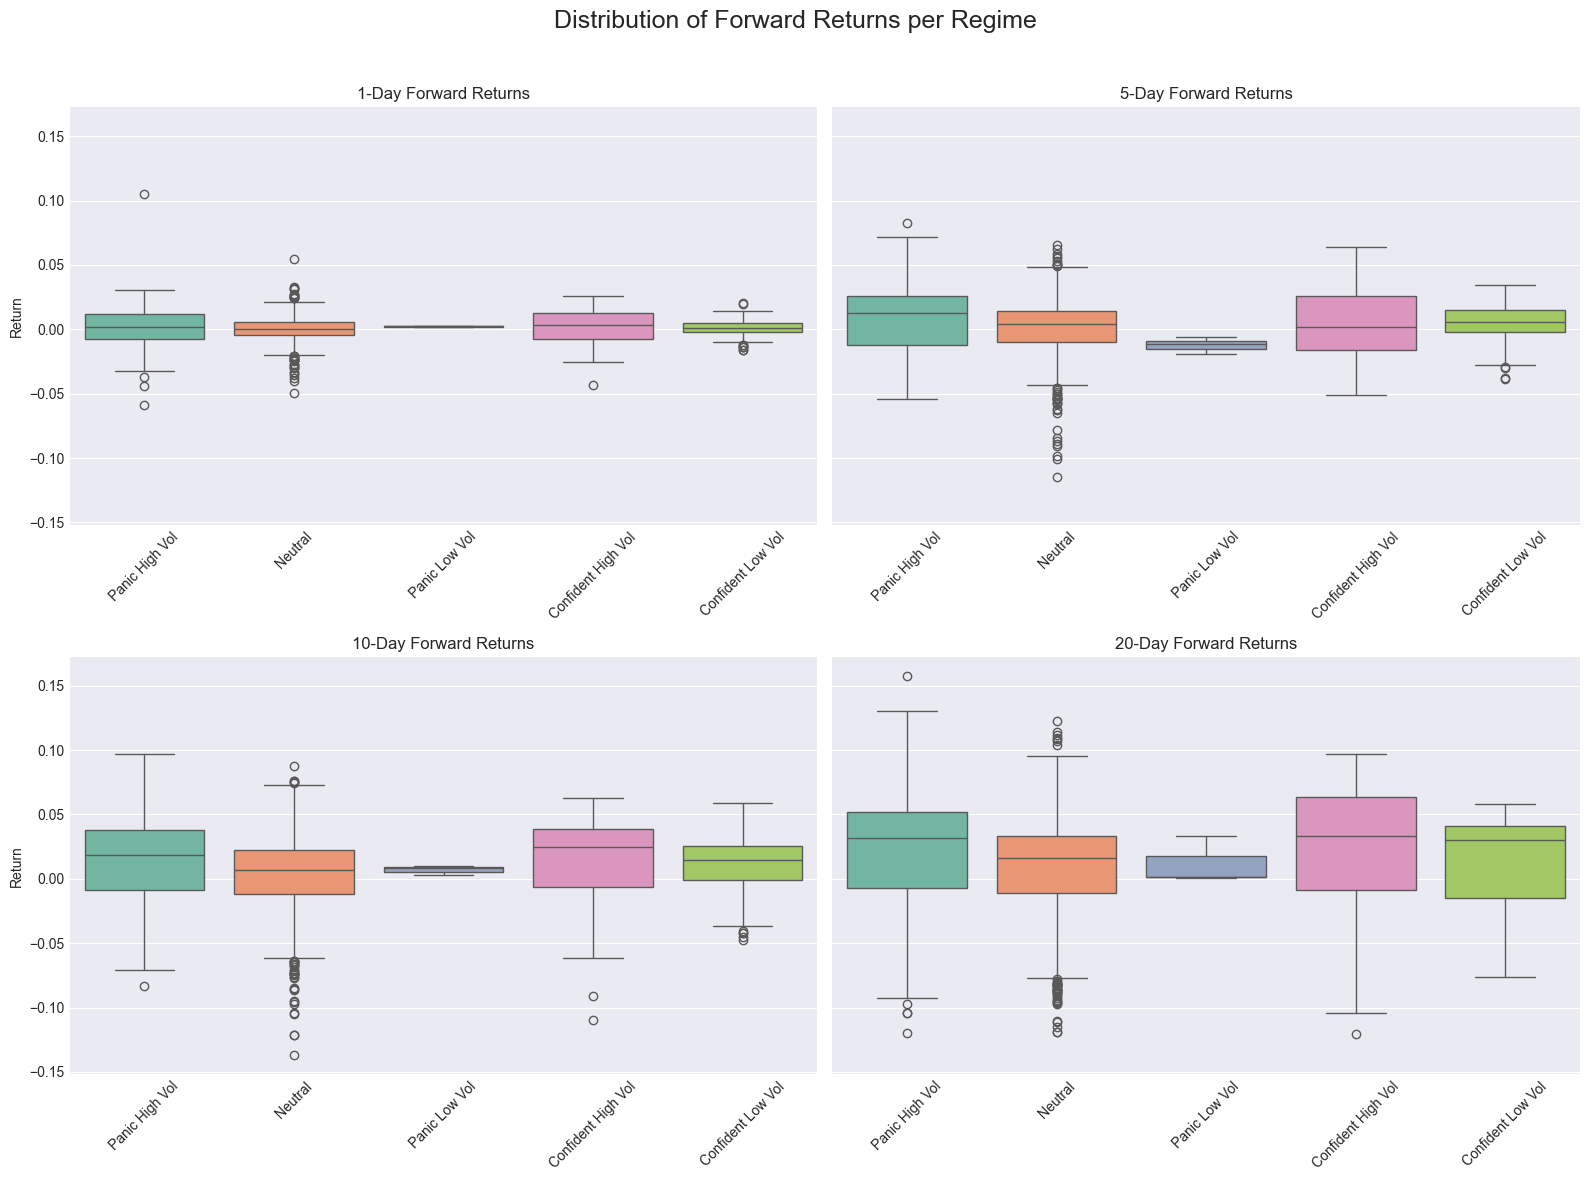

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True)
fig.suptitle('Distribution of Forward Returns per Regime', fontsize=18)

for i, days in enumerate([1, 5, 10, 20]):
    ax = axes[i//2, i%2]
    col = f'spy_fwd_return_{days}d'
    sns.boxplot(data=data, x='regime', y=col, ax=ax, palette='Set2')
    ax.set_title(f'{days}-Day Forward Returns')
    ax.set_xlabel('')
    ax.set_ylabel('Return')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Cumulative Returns Simulation

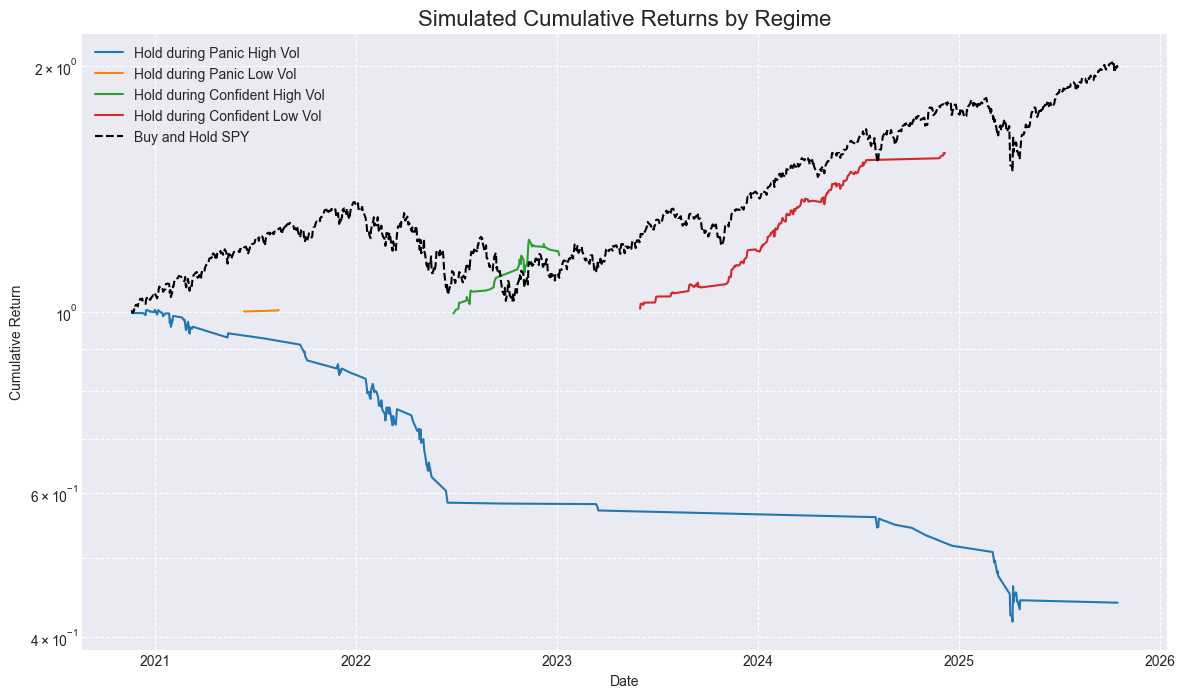

In [7]:
plt.figure(figsize=(14, 8))

for regime in data['regime'].unique():
    if regime == 'Neutral':
        continue
    regime_returns = data[data['regime'] == regime]['spy_return'].dropna()
    cumulative_returns = (1 + regime_returns).cumprod()
    plt.plot(cumulative_returns, label=f'Hold during {regime}')

benchmark_returns = (1 + data['spy_return']).cumprod()
plt.plot(benchmark_returns, label='Buy and Hold SPY', color='black', linestyle='--')

plt.title('Simulated Cumulative Returns by Regime', fontsize=16)
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

## 6. Conclusion

This section will be filled in after running the notebook and analyzing the plots.

In [9]:
tickers = ['^VIX', '^VVIX']
for t in tickers:
    data_raw = yf.download(t, period="max")
    print(data_raw.columns)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', '^VIX'),
            (  'High', '^VIX'),
            (   'Low', '^VIX'),
            (  'Open', '^VIX'),
            ('Volume', '^VIX')],
           names=['Price', 'Ticker'])
MultiIndex([( 'Close', '^VVIX'),
            (  'High', '^VVIX'),
            (   'Low', '^VVIX'),
            (  'Open', '^VVIX'),
            ('Volume', '^VVIX')],
           names=['Price', 'Ticker'])
